In [1]:
import sys,os
import numpy as np
import pandas as pd
# import h5py

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from wgpack.config import DATAPATH
from wgpack.rdradcp import rdradcp
from wgpack.adcp import motion_correct_ADCP_gps
from wgpack.nav import get_bearing


In [2]:
DATAPATH

'/Users/a1amador/src/wgpack/data'

In [3]:
# file path and name for input .PD0 file
fnam = "20220120_073001UTC_continuous.PD0"
adcp_filepath_in = os.path.join(DATAPATH,'adcp',fnam)
# file path and name for output .mat file
fnam_out, file_extension = os.path.splitext(adcp_filepath_in)

# read-in ADCP binaries
adcpr = rdradcp(adcp_filepath_in,num_av=1,nens=-1, baseyear=2000, despike='no',log_fp=None)



Opening file /Users/a1amador/src/wgpack/data/adcp/20220120_073001UTC_continuous.PD0


***** Apparently a VMDAS file 
2000: Adjust location by 14
2000: Adjust location by 14
Record begins at Thu Jan 20 07:30:10 2022
Ping interval appears to be 2.629999816417694s


Estimating 47462 ensembles in this file
   Reading 47462 ensembles, reducing by a factor of 1
Final result 47462 values
0
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.200

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
300
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adj

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
850
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adj

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
1400
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
1700
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
2250
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
2550
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
3100
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
3400
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
3950
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
4250
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
4500
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
4800
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
5350
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
5650
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
6200
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
6500
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
7050
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
7350
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
7900
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
8450
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
8750
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
9300
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
9600
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Ad

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
10150
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
10450
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
11000
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
11300
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
11550
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
11850
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
12400
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
12700
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
13250
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
13550
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
14100
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
14400
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
14950
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
15500
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
15800
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
16350
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
16650
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
17200
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
17500
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
18050
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
18350
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
18600
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
18900
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
19450
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
19750
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
20300
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
20600
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
21150
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
21450
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
22000
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
22550
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
22850
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
23400
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
23700
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
24250
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
24550
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
25100
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
25400
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
25650
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
25950
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
26500
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
26800
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
27350
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
27650
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
28200
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
28500
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
29050
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
29600
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
29900
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
30450
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
30750
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
31300
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
31600
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
32150
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
32450
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
32700
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
33000
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
33550
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
33850
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
34400
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
34700
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
35250
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
35550
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
36100
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
36650
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
36950
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
37500
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
37800
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
38350
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
38650
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
39200
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
39500
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
39750
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
40050
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
40600
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
40900
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
41450
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
41750
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
42300
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
42600
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
43150
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
43700
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
44000
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
44550
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
44850
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
45400
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
45700
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
46250
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
46550
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
46800
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
47100
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: A

.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust location by 14
.2000: Adjust 

In [15]:
import pyproj
import random
geodesic = pyproj.Geod(ellps='WGS84')

nav_elongitude = adcpr.nav_elongitude
nav_elatitude = adcpr.nav_elatitude

nn = 190
ii = random.randrange(0, len(nav_elongitude)-nn)
print(ii)

azfwd, azback, dx = geodesic.inv(nav_elongitude[ii - nn], nav_elatitude[ii - nn],
                                         nav_elongitude[ii + nn], nav_elatitude[ii + nn])
print(dx)
print((azfwd + 360) % 360)
# print(azfwd)
print(np.sin(np.deg2rad(azfwd)))
print(np.cos(np.deg2rad(azfwd)))

# ------------------------------------------------------------------------
# New method
# ------------------------------------------------------------------------

from geopy.distance import distance

p1 = (nav_elatitude[ii - nn], nav_elongitude[ii - nn])
p2 = (nav_elatitude[ii + nn], nav_elongitude[ii + nn])
print('------------------------------------------------------------------------')
print(distance(p1,p2).m)
print(get_bearing(p1,p2))
print(np.sin(np.deg2rad(get_bearing(p1,p2))))
print(np.cos(np.deg2rad(get_bearing(p1,p2))))


42141
926.138970861635
179.98629218702445
0.00023924646738830705
-0.9999999713805635
------------------------------------------------------------------------
926.1389708616348
179.98638202455706
0.00023767850669741646
-0.9999999717544633


In [6]:
# Apply motion correction
dt_gps = 90 # Motion correction time interval for GPS-derived velocities (s)
adcpm = motion_correct_ADCP_gps(adcpr, dt_gps, mag_dec=None, qc_flg=False,dtc=None)
print(adcpm.keys())


dict_keys(['time', 'longitude', 'latitude', 'ranges', 'Evel', 'Nvel', 'err_vel', 'cog_gps', 'sog_gps', 'sog_gpse', 'sog_gpsn', 'heading_float'])


In [7]:
# Find turning points using the RDP algorithm
from wgpack.RDP import rdp

# The RDP algorithm takes one parameter, the tolerance, which represents the maximum distance the simplified path 
# can stray from the original path. The larger the tolerance, the cruder the simplified path.
tolerance = 0.00025
# tolerance = 0.00005
points = tuple(zip(adcpm['longitude'], adcpm['latitude'])) 
simplified = np.array(rdp(list(points), tolerance))

# find times associated with turning
t_turn = []
for ss in simplified:
    # if both points match, then this is a turning point     
    jj = np.sum(ss==points,axis=1)==2
    t_turn.append(adcpm['time'][jj][0])

len(t_turn)

13

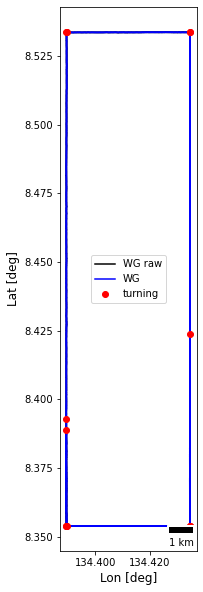

In [8]:
# Plot map
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from matplotlib import rcParams
from matplotlib.ticker import FormatStrFormatter
from matplotlib_scalebar.scalebar import ScaleBar
from geopy.distance import distance


_y = np.nanmedian(adcpm['latitude'])

# Define levels in z-axis where we want lines to appear
levels = np.linspace(-275,0,12)


# Initialize plot objects
rcParams['figure.figsize'] = 5, 10 # sets plot size
# set negative contours to be solid instead of dashed:
plt.rcParams['contour.negative_linestyle'] = 'solid'

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# plot Del Mar Mooring
# plot vehicle trajectory
ax.plot(adcpr.nav_slongitude,adcpr.nav_slatitude,'-k',label='WG raw')
ax.plot(adcpm['longitude'],adcpm['latitude'],'-b',label='WG')
ax.plot(simplified[:,0],simplified[:,-1],'or',label='turning')
# set legend
ax.legend()
# set aspect ratio
ax.set_aspect(aspect=1/np.cos(_y*np.pi/180))
# set axis labels
ax.set_xlabel('Lon [deg]', fontsize=12)
ax.set_ylabel('Lat [deg]', fontsize=12)
# # set axis limits
# ax.set_ylim(yL)
# ax.set_xlim(xL);

# Specify format of floats for tick labels
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))


# scalebar
dx = distance((_y,ax.get_xlim()[0]),(_y,ax.get_xlim()[0]+1)).m
scalebar = ScaleBar(dx=dx,units='m',location='lower right') 
plt.gca().add_artist(scalebar)



In [9]:
# Create time-base for block averaging
# time window
ta = adcpm['time'][0]
tb = adcpm['time'][-1]
# time interval for interpolation
DT = np.timedelta64(10,'m')

print('----------------------------------------------------------------------------------------------------------------')
print('creating unix time stamp (tt_unix)')
ta_unix = (pd.to_datetime(ta) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
tb_unix = (pd.to_datetime(tb) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
tt_unix = np.arange(ta_unix,
                    tb_unix,
                    DT.item().total_seconds())
# pandas datetime     
tt = pd.to_datetime(tt_unix.astype('datetime64[s]'))


----------------------------------------------------------------------------------------------------------------
creating unix time stamp (tt_unix)


In [10]:
# Block average vehicle dynamics, and ADCP velocities
import datetime
from geopy.distance import distance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats


# Maximum fraction of allowed NaNs per ADCP burst
nan_adcp_THRESH = 0.5

# Minimum number of pings per block average
dt_p2p = np.array(np.median(np.diff(adcpm['time'])), dtype='timedelta64[ns]').item()/1E9
THRESH_len = (DT/dt_p2p).astype('timedelta64[s]').astype(float) * 0.25

# -------------------------------------------------------------------------------------
# Process: block-averaging
# -------------------------------------------------------------------------------------
lon_adcp,lat_adcp = [],[]
sog_lonlat_adcp,cog_lonlat_adcp = [],[]
Nvel_adcp,Evel_adcp = [],[]
Nvel_std_adcp,Evel_std_adcp = [],[]
heading_std_adcp,pitch_std_adcp,roll_std_adcp=[],[],[]
heading_std_float,pitch_std_float,roll_std_float=[],[],[]
heading_mean_float,pitch_mean_float,roll_mean_float=[],[],[]
turn_bool = []
N_adcp = []
for i,t in enumerate(tt):
    # ADCP data    
    ii_adcp = np.where(np.logical_and(adcpm['time'] >= t-DT/2, adcpm['time'] <= t+DT/2))[0]
    N_adcp.append(len(ii_adcp))
    if len(ii_adcp)>THRESH_len:
        # ADCP coordinates
        lon_adcp.append(adcpm['longitude'][ii_adcp])
        lat_adcp.append(adcpm['latitude'][ii_adcp])
        # motion-corrected (interolated across sub)
        nvel = adcpm['Nvel'][:,ii_adcp].copy()
        evel = adcpm['Evel'][:,ii_adcp].copy()
        # Calculate cog and sog from WG MWG coordinates
        p1 = (adcpm['latitude'][ii_adcp][0],adcpm['longitude'][ii_adcp][0])
        p2 = (adcpm['latitude'][ii_adcp][-1],adcpm['longitude'][ii_adcp][-1])
        delt = (adcpm['time'][ii_adcp][-1]-adcpm['time'][ii_adcp][0])/np.timedelta64(1, 's')
        sogtmp = distance(p1,p2).m/delt if delt>0 else np.nan 
        sog_lonlat_adcp.append(sogtmp)
        cog_lonlat_adcp.append(get_bearing(p1,p2))
        # Identify turning:
        turn_bool.append(any(item in t_turn for item in adcpm['time'][ii_adcp]))
        
        # Mask velocity instances with turning (replace with nans)            
        if any(item in t_turn for item in adcpm['time'][ii_adcp]):
            print('Found turning')
            # find that turning instance
            ii_turn = np.where([item in t_turn for item in adcpm['time'][ii_adcp]])[0][0]
            # find times near turning point
            t_turn_a = adcpm['time'][ii_adcp][ii_turn]-np.timedelta64(int(dt_gps/2),'s')
            t_turn_b = adcpm['time'][ii_adcp][ii_turn]+np.timedelta64(int(dt_gps/2),'s')
            # mask velocities for times around that turning point
            iinan_turn = np.logical_and(adcpm['time'][ii_adcp]>t_turn_a,adcpm['time'][ii_adcp]<t_turn_b)
            nvel[:,iinan_turn] = np.nan
            evel[:,iinan_turn] = np.nan

        # time-average ADCP velocity profiles
        VN = np.nanmean(nvel,1)
        VE = np.nanmean(evel,1)
        VN_std = np.nanstd(adcpm['Nvel'][:,ii_adcp],1)
        VE_std = np.nanstd(adcpm['Evel'][:,ii_adcp],1)
        # Q/C ADCP velocity profiles
        Nvel_nans = np.sum(np.isnan(adcpm['Nvel'][:,ii_adcp]),axis=1)/len(ii_adcp)>nan_adcp_THRESH
        Evel_nans = np.sum(np.isnan(adcpm['Evel'][:,ii_adcp]),axis=1)/len(ii_adcp)>nan_adcp_THRESH
        VN[Nvel_nans] = np.nan
        VE[Evel_nans] = np.nan
        # store values         
        Nvel_adcp.append(VN)
        Evel_adcp.append(VE)
        Nvel_std_adcp.append(VN_std)
        Evel_std_adcp.append(VE_std)

        # ADCP attitude
        heading_std_adcp.append(stats.circstd(adcpm['heading_float'][ii_adcp],high=360, low=0, axis=None, nan_policy='omit'))
        pitch_std_adcp.append(stats.circstd(adcpr.pitch[ii_adcp],high=360, low=0, axis=None, nan_policy='omit'))
        roll_std_adcp.append(stats.circstd(adcpr.roll[ii_adcp],high=360, low=0, axis=None, nan_policy='omit'))

#         # float dynamics
#         # Apply circular statistics: mean
#         heading_mean_float.append(stats.circmean(adcpm['heading_float'][ii_adcp],high=360, low=0, axis=None, nan_policy='omit'))
#         pitch_mean_float.append(np.nanmean(pitch_float[ii_adcp]))
#         roll_mean_float.append(np.nanmean(roll_float[ii_adcp]))
#         # Apply circular statistics: standard deviation
#         heading_std_float.append(stats.circstd(heading_float[ii_adcp],high=360, low=0, axis=None, nan_policy='omit'))
#         pitch_std_float.append(stats.circstd(pitch_float[ii_adcp],high=360, low=0, axis=None, nan_policy='omit'))
#         roll_std_float.append(stats.circstd(roll_float[ii_adcp],high=360, low=0, axis=None, nan_policy='omit'))

    else:
        # mask if not enough data is available
        # ADCP data
        turn_bool.append(True)
        sog_lonlat_adcp.append(np.nan)
        cog_lonlat_adcp.append(np.nan)
        lon_adcp.append(np.nan)
        lat_adcp.append(np.nan) 
        Nvel_adcp.append(np.ones_like(adcpm['ranges'])*np.nan)
        Evel_adcp.append(np.ones_like(adcpm['ranges'])*np.nan)
        Nvel_std_adcp.append(np.ones_like(adcpm['ranges'])*np.nan)
        Evel_std_adcp.append(np.ones_like(adcpm['ranges'])*np.nan)
        # ADCP attitude
        heading_std_adcp.append(np.nan)
        pitch_std_adcp.append(np.nan)
        roll_std_adcp.append(np.nan)
        # vehicle motion statistics
        heading_mean_float.append(np.nan)
        pitch_mean_float.append(np.nan)
        roll_mean_float.append(np.nan)
        heading_std_float.append(np.nan)
        pitch_std_float.append(np.nan)
        roll_std_float.append(np.nan)        


# No. of measurements
N_adcp = np.array(N_adcp)
# turning
turn_bool = np.array(turn_bool)
# vehicle sog and cog
sog_lonlat_adcp = np.array(sog_lonlat_adcp)
cog_lonlat_adcp = np.array(cog_lonlat_adcp)
# vehicle motion statistics (mean)
heading_mean_float = np.array(heading_mean_float)
pitch_mean_float = np.array(pitch_mean_float)
roll_mean_float = np.array(roll_mean_float)
# vehicle motion statistics (standard deviation)
heading_std_float = np.array(heading_std_float)
pitch_std_float = np.array(pitch_std_float)
roll_std_float = np.array(roll_std_float)
# ADCP attitude
heading_std_adcp = np.array(heading_std_adcp)
pitch_std_adcp = np.array(pitch_std_adcp)
roll_std_adcp = np.array(roll_std_adcp)
# ADCP velocities
Nvel_adcp = np.array(Nvel_adcp).T
Evel_adcp = np.array(Evel_adcp).T
Nvel_std_adcp = np.array(Nvel_std_adcp).T
Evel_std_adcp = np.array(Evel_std_adcp).T
# ADCP coordinates
lon_adcp = np.array(lon_adcp)
lat_adcp = np.array(lat_adcp)
lon_bar,lat_bar = [],[]
for lon,lat in zip(lon_adcp,lat_adcp):
    lon_bar.append(np.nanmean(lon))
    lat_bar.append(np.nanmean(lat))


# mask contaminated bins due to glider sub acoustic interference
sub_depth1 = 8  # m (primary interference)
sub_depth2 = 16 # m (secondary interference)
sub_depth3 = 24 # m (tertiary interference)
jjsub1 = np.abs(adcpm['ranges']-sub_depth1).argmin()
jjsub2 = np.abs(adcpm['ranges']-sub_depth2).argmin()
jjsub3 = np.abs(adcpm['ranges']-sub_depth3).argmin()

# Evel
Evel_adcp[jjsub1,:]=np.nan
Evel_adcp[jjsub2,:]=np.nan
Evel_std_adcp[jjsub1,:]=np.nan
Evel_std_adcp[jjsub2,:]=np.nan
# Evel_adcp[ranges<10.5]=np.nan
# Evel_std_adcp[ranges<10.5]=np.nan
# Nvel
Nvel_adcp[jjsub1,:]=np.nan
Nvel_adcp[jjsub2,:]=np.nan
Nvel_std_adcp[jjsub1,:]=np.nan
Nvel_std_adcp[jjsub2,:]=np.nan
# Nvel_adcp[ranges<10.5]=np.nan
# Nvel_std_adcp[ranges<10.5]=np.nan



Found turning
Found turning
Found turning
Found turning
Found turning
Found turning
Found turning
Found turning
Found turning
Found turning
Found turning
Found turning
Found turning


/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_69028/2461362868.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lon_adcp = np.array(lon_adcp)
/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_69028/2461362868.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lat_adcp = np.array(lat_adcp)


/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_69028/3653545480.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax[0,0].pcolormesh(x,y,U_WG,vmin=-uL, vmax=uL,cmap = cm_msk)
/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_69028/3653545480.py:52: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0,1].pcolormesh(x,y,V_WG,vmin=-vL, vmax=vL, cmap = cm_msk)
/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_69028/3653545480.p

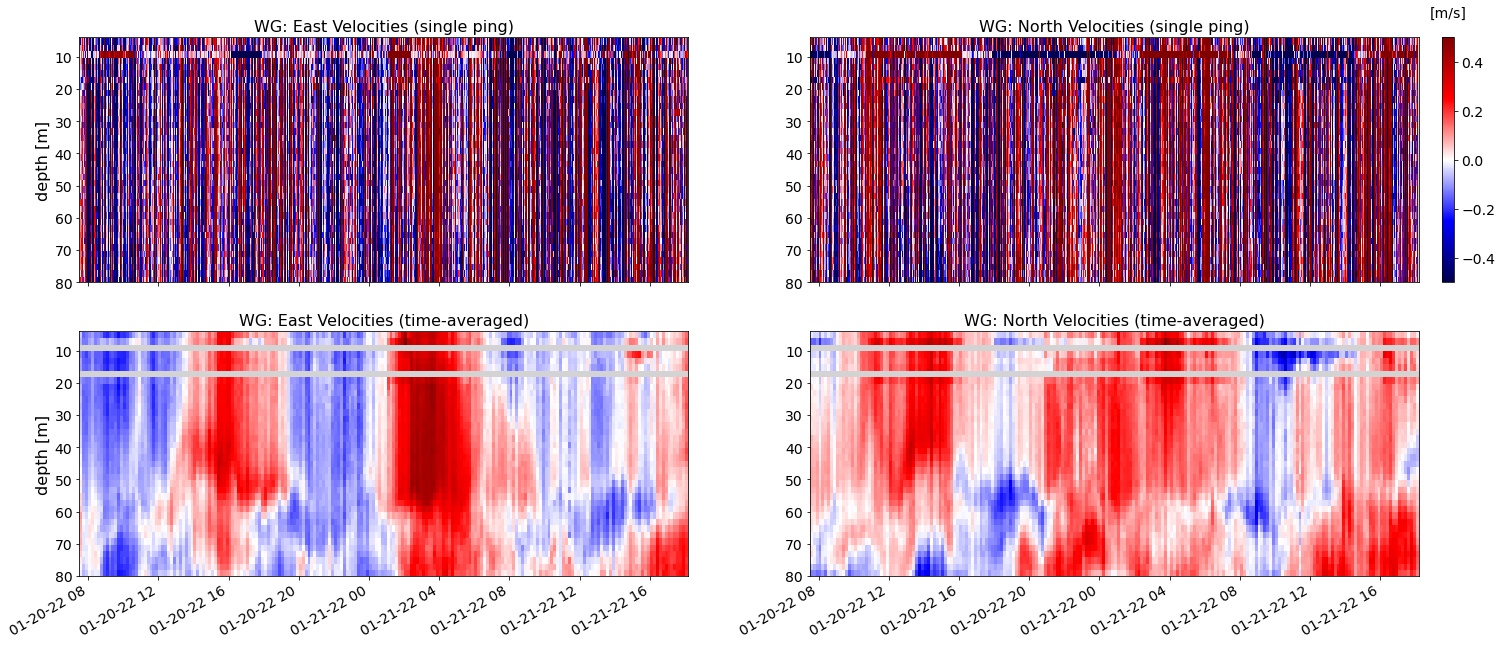

In [11]:
# ----------------------------------------------------------------------------------------------------------------------
# Plot results
# ----------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.gridspec as gridspec
import numpy as np

# create masked colormap
cm_msk = plt.get_cmap('seismic').copy()
cm_msk.set_bad(color='lightgray')

tt_WG = adcpm['time']
ranges_WG = adcpm['ranges']
# motion-corrected velocities
U_WG = adcpm['Evel']
V_WG = adcpm['Nvel']
# motion-corrected and filtered velocities
Uf_WG = Evel_adcp
Vf_WG = Nvel_adcp

# Plot WG water velocities
yL = [4,80]
uL = 0.5
vL = 0.5
fntsz = 16
labsz = 14
ylab_str = 'depth [m]'

# Do not show vehicle heading
heights = [1,1]
nrows = 2
ncols = 2
gs_kw = dict(height_ratios=heights)
fig, ax = plt.subplots(ncols=ncols, nrows=nrows,
                            sharex=True,
                            sharey=False,
                            gridspec_kw=gs_kw,
                            figsize=(24, 11))


# WG: East Vel
x,y = np.meshgrid(tt_WG,ranges_WG)
c = ax[0,0].pcolormesh(x,y,U_WG,vmin=-uL, vmax=uL,cmap = cm_msk)
ax[0,0].set_ylim(yL)
ax[0,0].set_ylabel(ylab_str,fontsize=fntsz)
ax[0,0].set_title('WG: East Velocities (single ping)',fontsize=fntsz)
ax[0,0].invert_yaxis()

# WG: North Vel
x,y = np.meshgrid(tt_WG,ranges_WG)
ax[0,1].pcolormesh(x,y,V_WG,vmin=-vL, vmax=vL, cmap = cm_msk)
ax[0,1].set_ylim(yL)
ax[0,1].set_title('WG: North Velocities (single ping)',fontsize=fntsz)
ax[0,1].invert_yaxis()

# WG: East Vel (filtered)
x,y = np.meshgrid(tt,ranges_WG)
c = ax[1,0].pcolormesh(x,y,Uf_WG,vmin=-uL, vmax=uL,cmap = cm_msk)
ax[1,0].set_ylim(yL)
ax[1,0].set_ylabel(ylab_str,fontsize=fntsz)
ax[1,0].set_title('WG: East Velocities (time-averaged)',fontsize=fntsz)
ax[1,0].invert_yaxis()

# WG: North Vel (filtered)
x,y = np.meshgrid(tt,ranges_WG)
ax[1,1].pcolormesh(x,y,Vf_WG,vmin=-vL, vmax=vL, cmap = cm_msk)
ax[1,1].set_ylim(yL)
ax[1,1].set_title('WG: North Velocities (time-averaged)',fontsize=fntsz)
ax[1,1].invert_yaxis()

# rotate and align the tick labels so they look better
ax[0,0].tick_params(labelsize=labsz)
ax[1,0].tick_params(labelsize=labsz)
ax[0,1].tick_params(labelsize=labsz)
ax[1,1].tick_params(labelsize=labsz)

# Define the date format
date_form = DateFormatter("%m-%d-%y %H")
ax[1,1].xaxis.set_major_formatter(date_form)
fig.autofmt_xdate()

# add a colorobar
gs = gridspec.GridSpec(ncols=3, nrows=nrows, height_ratios=gs_kw['height_ratios'], right=0.95,figure=fig)
axc = fig.add_subplot(gs[0,-1])
axc.set_visible(False)
cbar = fig.colorbar(c, ax=axc,orientation='vertical')
cax = cbar.ax
# Add label on top of colorbar.
cbar.ax.set_xlabel("[m/s]\n",fontsize=labsz)
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=labsz)

fig.show()

/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_69028/1713111215.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax[0].pcolormesh(x,y,Uf_WG,vmin=-uL, vmax=uL,cmap = cm_msk)
/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_69028/1713111215.py:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(x,y,Vf_WG,vmin=-vL, vmax=vL, cmap = cm_msk)


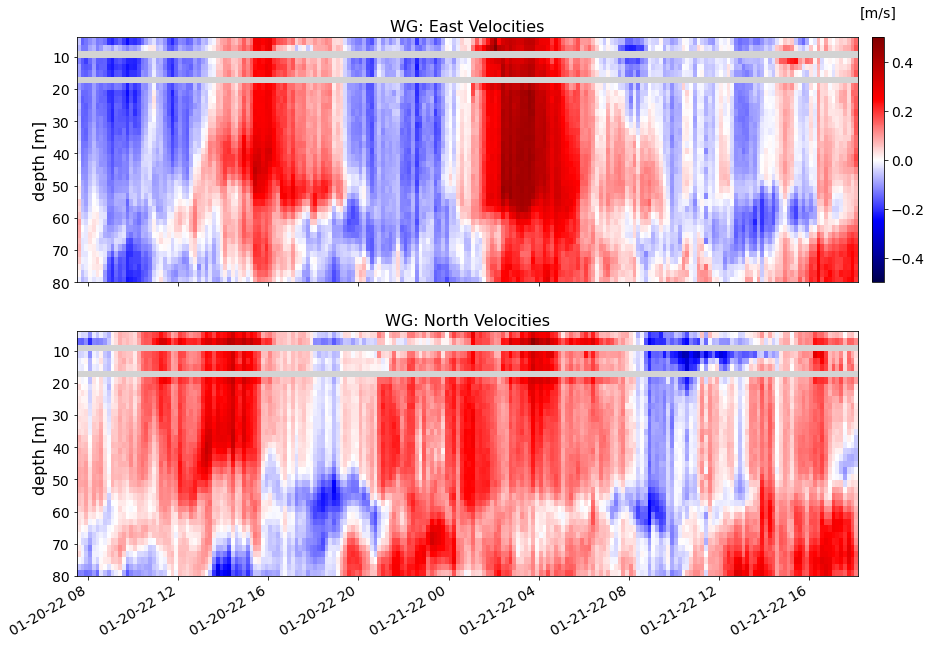

In [12]:
# ----------------------------------------------------------------------------------------------------------------------
# Plot results
# ----------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.gridspec as gridspec
import numpy as np

# create masked colormap
cm_msk = plt.get_cmap('seismic').copy()
cm_msk.set_bad(color='lightgray')

tt_WG = adcpm['time']
ranges_WG = adcpm['ranges']

# motion-corrected and time-averaged velocities
Uf_WG = Evel_adcp
Vf_WG = Nvel_adcp

# Plot WG water velocities
yL = [4,80]
uL = 0.5
vL = 0.5
fntsz = 16
labsz = 14
ylab_str = 'depth [m]'

# Do not show vehicle heading
heights = [1,1]
nrows = 2
ncols = 1
gs_kw = dict(height_ratios=heights)
fig, ax = plt.subplots(ncols=ncols, nrows=nrows,
                            sharex=True,
                            sharey=False,
                            gridspec_kw=gs_kw,
                            figsize=(14, 11))


# WG: East Vel
x,y = np.meshgrid(tt,ranges_WG)
c = ax[0].pcolormesh(x,y,Uf_WG,vmin=-uL, vmax=uL,cmap = cm_msk)
ax[0].set_ylim(yL)
ax[0].set_ylabel(ylab_str,fontsize=fntsz)
ax[0].set_title('WG: East Velocities',fontsize=fntsz)
ax[0].invert_yaxis()

# WG: North Vel
x,y = np.meshgrid(tt,ranges_WG)
ax[1].pcolormesh(x,y,Vf_WG,vmin=-vL, vmax=vL, cmap = cm_msk)
ax[1].set_ylim(yL)
ax[1].set_ylabel(ylab_str,fontsize=fntsz)
ax[1].set_title('WG: North Velocities',fontsize=fntsz)
ax[1].invert_yaxis()


# rotate and align the tick labels so they look better
ax[0].tick_params(labelsize=labsz)
ax[1].tick_params(labelsize=labsz)

# Define the date format
date_form = DateFormatter("%m-%d-%y %H")
ax[1].xaxis.set_major_formatter(date_form)
fig.autofmt_xdate()

# add a colorobar
gs = gridspec.GridSpec(ncols=3, nrows=nrows, height_ratios=gs_kw['height_ratios'], right=0.95,figure=fig)
axc = fig.add_subplot(gs[0,-1])
axc.set_visible(False)
cbar = fig.colorbar(c, ax=axc,orientation='vertical')
cax = cbar.ax
# Add label on top of colorbar.
cbar.ax.set_xlabel("[m/s]\n",fontsize=labsz)
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=labsz)

# fig.show()
